In [1]:
from seasonal_challenge import multiple_challenges

example_EIRs = [1, 1, 1, 1, 1, 2, 4, 8, 16, 4, 1, 1]

da = multiple_challenges(n_people=4,
                         duration=30*365,
                         monthly_eirs=example_EIRs)

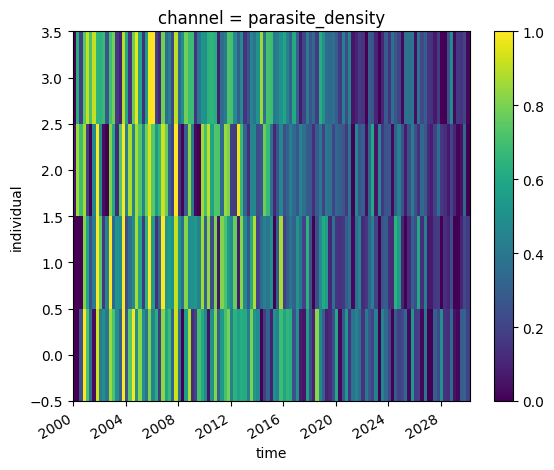

In [3]:
prev_by_season = (da.loc[dict(channel='parasite_density')] > 16).resample(time='3M').mean()
prev_by_season.plot()

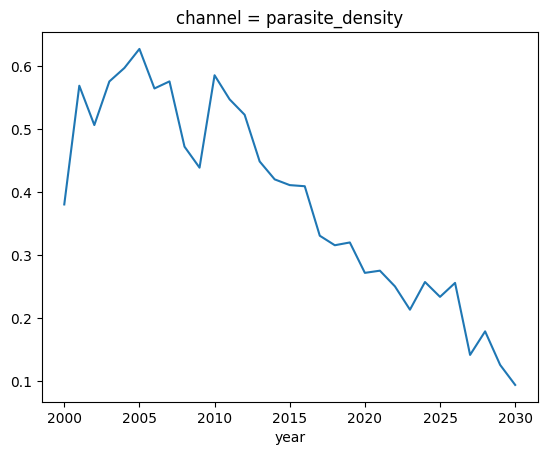

In [4]:
avg_prev_by_age = prev_by_season.groupby('time.year').mean().mean(dim='individual')
avg_prev_by_age.plot()

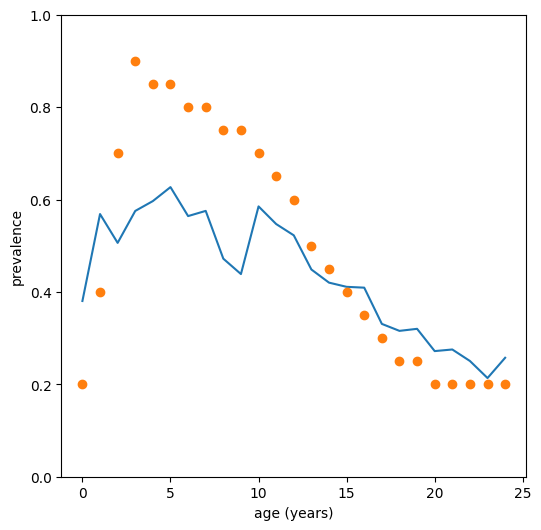

In [5]:
import matplotlib.pyplot as plt

example_prev_by_age_ref = [0.2, 0.4, 0.7, 0.9, 0.85, 
                           0.85, 0.8, 0.8, 0.75, 0.75, 
                           0.7, 0.65, 0.6, 0.5, 0.45, 
                           0.4, 0.35, 0.3, 0.25, 0.25,
                           0.2, 0.2, 0.2, 0.2, 0.2]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set(ylim=(0, 1), ylabel='prevalence', xlabel='age (years)')
ages = range(len(example_prev_by_age_ref))
ax.plot(ages, avg_prev_by_age[:len(ages)], '-')
ax.plot(ages, example_prev_by_age_ref, 'o')


In [130]:
import numpy as np

def kl(p, q):

    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    return np.sum(np.where(p != 0, p*np.log(p/q), 0))

In [131]:
kl(example_prev_by_age_ref, avg_prev_by_age[:len(ages)])

1.829272605700438

In [6]:
from emodlib.malaria import IntrahostComponent

def objective(trial):

    n_people = 4
    duration = 30*365

    antigen_switch_rate = trial.suggest_float("Antigen_Switch_Rate", 5e-10, 5e-8, log=True)
    
    IntrahostComponent.set_params(dict(infection_params=dict(Antigen_Switch_Rate=antigen_switch_rate)))

    da = multiple_challenges(n_people=n_people, duration=duration, monthly_eirs=example_EIRs)
    
    prev_by_season = (da.loc[dict(channel='parasite_density')] > 16).resample(time='3M').mean()

    avg_prev_by_age = prev_by_season.groupby('time.year').mean().mean(dim='individual')
    n_ages = min(len(example_prev_by_age_ref), len(avg_prev_by_age))
    return kl(example_prev_by_age_ref[:n_ages], avg_prev_by_age[:n_ages])

In [7]:
import optuna

study = optuna.create_study(study_name='minimize_KL', direction='minimize')
study.optimize(objective, n_trials=5)

[I 2023-06-06 17:37:53,784] A new study created in memory with name: minimize_KL
[W 2023-06-06 17:37:54,918] Trial 0 failed with parameters: {'Antigen_Switch_Rate': 1.2565264095887917e-09} because of the following error: NameError("name 'kl' is not defined").
Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_35845/3635694128.py", line 18, in objective
    return kl(example_prev_by_age_ref[:n_ages], avg_prev_by_age[:n_ages])
NameError: name 'kl' is not defined
[W 2023-06-06 17:37:54,925] Trial 0 failed with value None.


NameError: name 'kl' is not defined